# PHYS250 Final Project: Radiation Beam Dosage

### Introduction


### Assignment Details



#### 1: Photon Simulation, Compton Scattering


*Optional*
1. Extrapolate to 3D
1. Add multiple tissues
1. Add different types of particles

In [9]:
# Import the usual numpy and matplotlib libraries for numerical operations and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from numpy import random as rng
from scipy import constants as const

# m_e in MeV
m_e_MeV = const.physical_constants['electron mass energy equivalent in MeV'][0]
    
# h in MeV / Hz
h_MeV = .000001 * const.physical_constants['Planck constant in eV/Hz'][0]

In [115]:
# the stationary particle within the tissue
# are we violating conservation of momentum?
class Cell:
    def __init__(self, coord, mass, radius):
        self.coord = coord
        self.mass = mass
        self.radius = radius
    
    def get_coord(self):
        return self.coord  
    def get_mass(self):
        return self.mass
    def get_radius(self):
        return self.radius
    def set_coord(self):
        return self.coord  
    def set_mass(self):
        return self.mass
    def set_radius(self):
        return self.radius

# lattice of cells that represent a piece of matter (tissue)
# coord is the bottom left corner (we'll figure out how to orient it properly dw)
class Lattice:
    def __init__(self, dim, coord=(0,0), cell_width=1):
        self.rows = dim[0]
        self.cols = dim[1]
        self.lattice = np.full((self.rows, self.cols), 0) # energy values, start at 0
        self.coord = np.array(coord)
        self.cell_width = cell_width
    
    # increase the energy of a certain cell
    # takes cell indices (row, col)
    def increaseEnergy(self, cell, E):
        row = cell[0]
        col = cell[1]
        self.lattice[row,col] += E
        return self.lattice

    # finds the lattice indices for the cell that a point is in    
    def findCell(self, point):
        x = point[0]
        y = point[1]
        
        x_cell = (point[0] - self.coord[0]) // self.cell_width
        x_cell = int(x_cell)
        y_cell = (point[1] - self.coord[1]) // self.cell_width
        y_cell = int(y_cell)
        
        return (y_cell, x_cell)
    
    # find the cells that are in a boxed region, calculated the average energy among them
    def get_AveEnergyToRegion(self, xbounds, ybounds):
        bottom_left = self.findCell((xbounds[0], ybounds[0]))
        top_right = self.findCell((xbounds[1], ybounds[1]))
        
        total_E = 0
        for i in range(bottom_left[0], top_right[0]+1):
            for j in range(bottom_left[1], top_right[1]+1):
                total_E += self.lattice[i][j]

        return total_E / (i*j)
    
    def get_MaxE(self):
        return np.argmax(self.lattice)
    
    def get_xbounds(self):
        x = self.coord[0]
        return (x, x+(self.cell_width * self.cols))
    def get_ybounds(self):
        y = self.coord[1]
        return (y, y+(self.cell_width * self.rows))
    
    def get_rows(self):
        return self.rows
    def get_cols(self):
        return self.cols
    def get_coord(self):
        return self.coord
    def get_cell_width(self):
        return self.cell_width
    def get_lat(self):
        return self.lattice
    def get_lattice(self):
        return self.lattice
    def get_latcoord(self):
        return np.flip(self.lattice)

In [124]:
# the photon particle that flies through the matter, undergoing scattering
# yes we are violating HUP
# coord is an array (x, y)
# momentum is an array (magnitude, angle)
class Photon:
    def __init__(self, coord, energy, angle=0):
        self.coord = coord
        self.energy = energy
        self.angle = angle
        
    # gets the travel distance for a particle through material
    # based on normal distribution from 
    def getFreePath(self):
        mean_dist = 1.0 / self.getLinCoeff()
        dist_var = np.sqrt(mean_dist)
        dist = rng.normal(mean_dist, dist_var)
        return dist
    def getLinCoeff(self):
        E = self.get_energy()
        # only for water right now - can create others if available        
        lin_coeff = np.power(E,-2.547) * (.001106*np.power(E,3) + .06938*E*E - .002516*E + .00006085)
        return lin_coeff
    
    
    # makes a photon undergo inelastic Compton scattering
    def comptonScatter(self):
        old_E = self.get_energy() # keep the original energy so we can track the loss
        theta = rng.random() * 2 * np.pi # random scatter angle
        new_E = compton(self.energy, theta)

        self.set_energy(new_E)
        self.set_angle(theta)
        
        energy_loss = old_E - new_E

        return energy_loss
    
    
    # transport the photon forward a random distance (chosen on distribution from linear atten coeff)
    def moveForward(self):
        '''
        get the distance to travel from distribution & energy
        move that distance in the angle of the momentum
        '''
        dist = self.getFreePath()
        angle = self.get_angle()
        
        x_diff = dist * np.cos(angle)
        y_diff = dist * np.sin(angle)
        
        new_coord = (self.get_coord()[0] + x_diff, self.get_coord()[1] + y_diff)
        
        self.set_coord(new_coord)
        return dist
    
    
    # check if the photon is inside a lattice
    # if so, return its index in the lattices list
    def insideMaterial(self, lattices):
        '''
        - using the bounds of the material box, figure out if the particle is inside it
            - rows, cols, check both
        - return the floored coordinates
        - create a overlying function that moves particle, checks if inside
            - if no, delete the particle
            - if yes, Compton scatter, deposit energy at floored coords
            - repeat until low on energy
        '''
        x = self.coord[0]
        y = self.coord[1]
        
        # run through the lattices, see if inside any of them
        for index, lattice in enumerate(lattices):
            x_bounds = lattice.get_xbounds()
            y_bounds = lattice.get_ybounds()

            if x_bounds[0] <= x <= x_bounds[1] and y_bounds[0] <= y <= y_bounds[1]: # inside the box of points
                return index
            else:
                continue
        return -1 # if not in any lattice, return -1

    def depositEnergy(self, lattice, E):
        # find the square that the photon is currently in, deposit energy there
        #cell = np.floor(self.get_coord())
        #cell = cell.astype(int)
        cell = lattice.findCell(self.coord)
        lattice.increaseEnergy(cell, E)
    
    def runPhoton(self, lattices):
        max_airdist = 100 # max distance allowed for a photon to travel through air before it stops
        air_dist = 0 # counter of distance traveled through air
        
        # repeatedly move forward and Compton scatter until below a certain energy threshold
        while self.energy > .05:
            dist = self.moveForward() # move a distance forward
            lattice_index = self.insideMaterial(lattices) # index of which lattice the particle is in (-1 if none)
            
            if lattice_index != -1: # if inside any lattice
                energy_loss = self.comptonScatter() # photon loses energy and changes direction
                self.depositEnergy(lattices[lattice_index], energy_loss)
                
            else: # if not in a lattice, move forward a while until it is or runs out of steam
                air_dist += dist
                if air_dist > max_airdist:
                    self.set_energy(0) # stops the photon run
                continue
        
    def get_coord(self):
        return self.coord
    def get_energy(self):
        return self.energy
    def get_angle(self):
        return self.angle
    def set_coord(self, coord):
        self.coord = coord
    def set_energy(self, energy):
        self.energy = energy
    def set_angle(self, angle):
        self.angle = angle

In [110]:
# has a coordinated source, max energy of delivered photons, and collimated angle range
# placed when initialized, then call turnOn to fire
# direction is an angle (which way is it pointing)
# angle_range is the angular beam width
class Beam:
    def __init__(self, coord, direction, energy=10, nphotons=10000, angle_range=np.pi/2):
        #self.coord = np.flip(coord)
        #self.direction = -1*(direction - (np.pi/2))
        self.coord = coord
        self.direction = direction
        self.energy = energy
        self.nphotons = nphotons
        self.angle_range = angle_range
    
    # fire the beam
    # can specify parameters when firing, otherwise will use whatever is stored
    def shoot(self, blocks):
        for i in range(self.nphotons):
            half_range = self.angle_range / 2
            rand_angle = rng.rand() * self.angle_range + (self.direction - half_range)
            
            rand_E = rng.rand() * self.energy # MeV
    
            photon = Photon(self.coord, rand_E, rand_angle)
            photon.runPhoton(blocks)

    def get_coord(self):
        return self.coord
    def get_energy(self):
        return self.energy
    def get_direction(self):
        return self.direction
    def get_nphotons(self):
        return self.nphotons
    def get_angle_range(self):
        return self.angle_range
    
    def set_coord(self, coord):
        self.coord = coord
    def set_energy(self, energy):
        self.energy = energy
    def get_direction(self, direction):
        self.direction = direction
    def get_nphotons(self, nphotons):
        self.nphotons = nphotons
    def get_angle_range(self, angle_range):
        self.angle_range = angle_range

In [135]:
# Cell for other functions

# compton scattering with photon energy
# MeV units
def compton(E, theta):
    denom = 1 + ((E / m_e_MeV)*(1-np.cos(theta)))
    return E / denom

# generate a PDD curve
# position is the position along the x-axis (for up or down, y-axis vice versa)
# width is how many points to consider on each side of the central line
def plotPDD(lattice, direction='up', position=0, width=2):
    '''
    - get the average energy values of the lattice at position (position, 0) and directly 2ish to the right and left
    - increment y value by 1, do again
    '''
    steps = np.array([])
    av_Es = np.array([])
    
    if direction == 'up':
        for y_val in range(lattice.get_rows()):
            xbounds = (position-width, position+width)
            av_E = lattice.get_AveEnergyToRegion(xbounds, (y_val,y_val))
            
            steps = np.append(steps, y_val)
            av_Es = np.append(av_Es, av_E)
    
    # plot the values as a scatter plot
    fig, ax = plt.subplots()
    ax.scatter(steps, av_Es, label='Energy Deposited')
    ax.set_xlabel('Depth (cm)')
    ax.set_ylabel('Energy (MeV)')
    
    fig.legend()

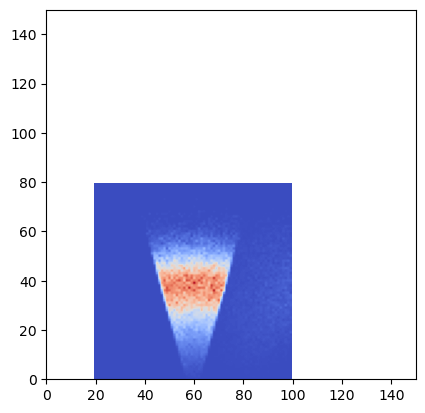

C:\Users\brady\AppData\Local\Temp\ipykernel_29756\2606149086.py:62: RuntimeWarning: divide by zero encountered in long_scalars
  return total_E / (i*j)


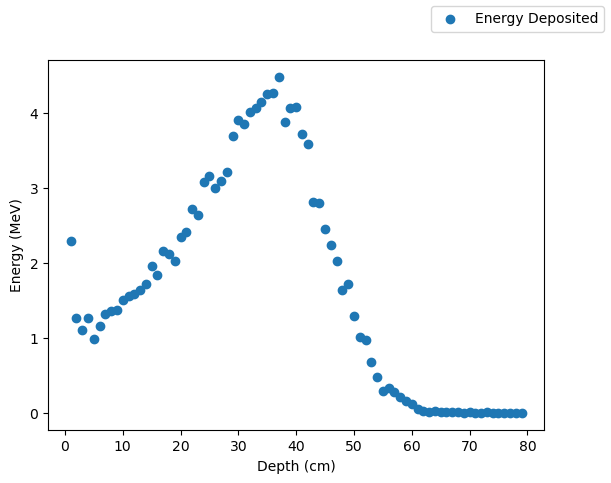

In [136]:
# TESTING TESTING

#block = Lattice((100,150))
#blocks = [block]

block2 = Lattice((80,80), coord=(20,0))
blocks = [block2]

#beam1 = Beam((-10,-10), np.pi/4, angle_range=np.pi/4)
#beam1.shoot(blocks)
beam2 = Beam((60,-10), np.pi/2, energy=20, angle_range=np.pi/6, nphotons=100000)
beam2.shoot(blocks)


#print(block.get_lat())    

fig, ax = plt.subplots()

for block in blocks:
    transform = mtransforms.Affine2D().translate(block.get_coord()[0],block.get_coord()[1])
    #im = ax.imshow(block.get_lat(), cmap='coolwarm', transform=transform + ax.transData)
    plt.imshow(block.get_lat(), cmap='coolwarm', transform=transform + ax.transData)

#ax.invert_yaxis()
#plt.colorbar()

ax.set_xlim(0,150)
ax.set_ylim(0,150)
plt.show()

plotPDD(block2, 'up', 60)

#print(block.get_AveEnergyToRegion((60,65),(20,30)))
#print(block.get_AveEnergyToRegion((60,65),(80,100)))

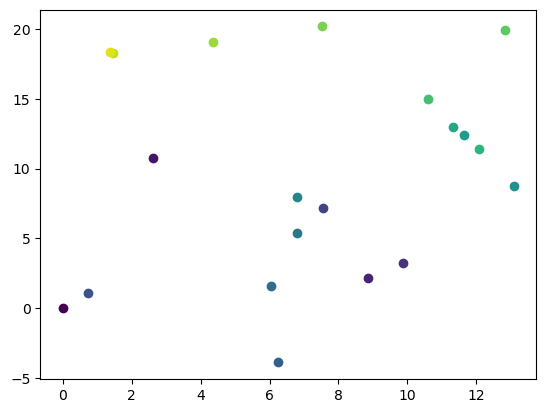

In [20]:
# TESTING TESTING
photon = Photon([0,0], [1, 0])

# Create a colormap
cmap = plt.get_cmap('viridis')
nsteps = 20

fig, ax = plt.subplots()

for i in range(nsteps):
    color = cmap(i / nsteps) # Get color from colormap based on index
    
    ax.plot(photon.get_coord()[0], photon.get_coord()[1], 'o', color=color)
    photon.comptonScatter()
    photon.moveForward()

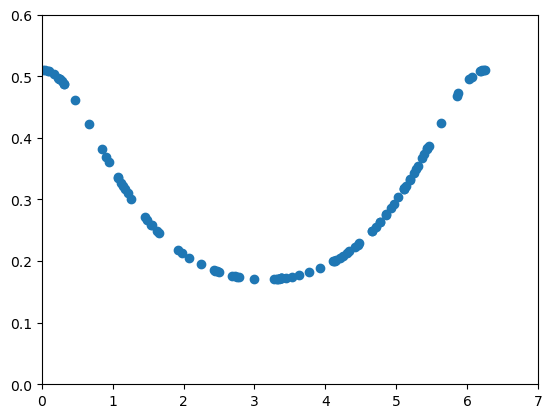

In [11]:
# confirm Compton scattering is working properly
data = np.zeros(100)
thetas = [rng.random() * 2 * np.pi for i in range(100)]
for i in range(len(data)):
    data[i] = compton(.511, thetas[i])


#print(data[0:100])

fig, ax = plt.subplots()

ax.scatter(thetas, data)
ax.set_xlim(0, 7)
ax.set_ylim(0,.6)

plt.show()

In [9]:
# creates a lattice of (x,y) coordinates
# each atom individually can know its coordinates
# N rows, M columns
#def createRectLattice(N,M):
#    x_values = np.arange(M)
#    y_values = np.arange(N)
#                         
#    lattice = np.empty((N,M))
##    
#    for x in x_values:
#        for y in y_values:
#            lattice[x][y] = (x,y)
#            
#    print(lattice)

# creates lattice of atoms of uniform mass and radius
#def createAtomLattice(N, M, mass, radius):
##    x_values = np.arange(M)
#    y_values = np.arange(N)
#    totalatoms = N * M # total number of atoms
#                         
#    atomlattice = np.array([])
#    
#    for x in (x_values):
#        for y in (y_values):
#            coord = (x,y)
#            
#            atom = Atom(coord, mass, radius)
#            atomlattice = np.append(atomlattice, atom)
#    
#    return atomlattice